# Performance plots for stars with asteroseismic information

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [3]:
seis = pyfits.getdata('data/GALAH_seis.fits',1)
free = pyfits.getdata('data/GALAH_seis_free.fits',1)
lbol = pyfits.getdata('data/GALAH_seis_lbol.fits',1)
iraf = pyfits.getdata('data/iraf_seis_lbol.fits',1)
#seis_field =  np.genfromtxt('../fields/GALAH_seis',dtype=float)

match = (
    (seis['E_TEFF'] > 0) & (free['E_TEFF'] > 0) & (lbol['E_TEFF'] > 0) & 
    (seis['FEH'] > -4) & (free['FEH'] > -4) & (lbol['FEH'] > -4) & 
    (seis['FEH'] < 0.5) & (free['FEH'] < 0.5) & (lbol['FEH'] < 0.5) & 
    (np.abs(seis['LOGG']-free['LOGG']) < 0.75) & (np.abs(seis['LOGG']-lbol['LOGG']) < 0.4) & 
    (seis['LOGG'] > 1.75) & (lbol['LOGG'] < 3.5)
    )

In [4]:
def plot_density(x, y, bins=100, range=None, normed=False, weights=None, 
                 scaling=None, reduce_fn='sum', smooth=0, ax=None, **kwargs):
    """
    Compute the bi-dimensional histogram of two data samples.

    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:

        * If int, the number of bins for the two dimensions (nx=ny=bins).
        * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
        * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
        * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
        * A combination [int, array] or [array, int], where int
            is the number of bins and array is the bin edges.

    range : array_like, shape(2,2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the `bins` parameters):
        ``[[xmin, xmax], [ymin, ymax]]``. All values outside of this range
        will be considered outliers and not tallied in the histogram.
    normed : bool, optional
        If False, returns the number of samples in each bin. If True,
        returns the bin density ``bin_count / sample_count / bin_area``.
    weights : array_like, shape(N,), optional
        An array of values ``w_i`` weighing each sample ``(x_i, y_i)``.
        Weights are normalized to 1 if `normed` is True. If `normed` is
        False, the values of the returned histogram are equal to the sum of
        the weights belonging to the samples falling into each bin.
    """
    import pylab as plt
    from scipy.ndimage import gaussian_filter

    ind = (np.isfinite(x) & np.isfinite(y))
    if False in ind:
        print("Warning: Not all values are finite.")
        w = weights
        if w is not None:
            w = w[ind]
        n, bx, by = plt.histogram2d(x[ind], y[ind], bins=bins, range=range, normed=normed,
                                    weights=w)
    else:
        n, bx, by = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                    weights=weights)

    if reduce_fn.lower() in ('average', 'mean', 'avg'):
        n0, _, _ = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                   weights=None)
        ind = n0 > 0
        n = n.astype(float)
        n[ind] /= n0[ind].astype(float)
    n[(n==0)] = np.nan

    defaults = dict(cmap='RdYlBu_r', origin='lower', aspect='auto',
                    interpolation='nearest')
    defaults.update(**kwargs)
    extent = (bx[0], bx[-1], by[0], by[-1])

    if smooth > 0:
        gaussian_filter(n, smooth, output=n)

    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
        
    if scaling is None:
        scaling = 'None'
    s = scaling.lower().replace(' ', '')
    if s in (None, 'none', 'count'):
        return ax.imshow(n.T, extent=extent, **defaults)#, n
    else:
        if s in ('log', 'log(n)', 'log10', 'log(count)'):
            return ax.imshow(np.log10(n).T, extent=extent, **defaults)#, np.log10(n)
        elif s in ('log(n+1)', 'log(count+1)'):
            return ax.imshow(np.log10(n + 1).T, extent=extent, **defaults)#, np.log10(n + 1)

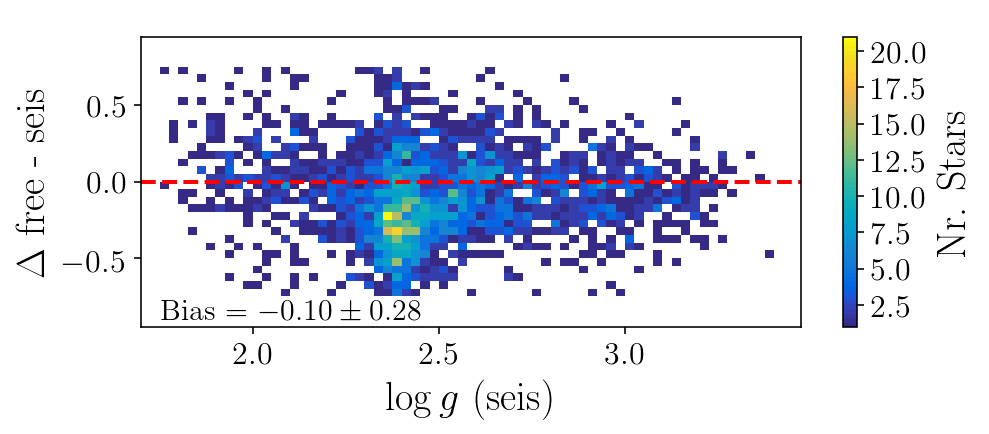

In [9]:
def plot_logg_comparsion_free():
    
    f, ax1= plt.subplots(1, figsize=(7,3))
    p3, x3, y3, s3 = ax1.hist2d(
        seis['LOGG'][match],
        free['LOGG'][match] - seis['LOGG'][match],
        bins = (np.arange(1.7,3.5,0.025),np.arange(-1.1,1.11,0.05)), 
        cmin = 1, 
        cmap = parula
        )
    ax1.axhline(0,c='r',lw=2,ls='dashed')
    ax1.set_ylim(-0.95,0.95)
    c3=plt.colorbar(s3,ax=ax1)
    c3.set_label('Nr. Stars')
    ax1.text(0.03,0.03,r'Bias = $'+"{b:5.2f} \pm {s:5.2f}".format(b=np.mean(free['LOGG'][match] - seis['LOGG'][match]),s=np.std(free['LOGG'][match] - seis['LOGG'][match]))+'$',transform=ax1.transAxes,fontsize=15)
    ax1.set_xlabel(r'$\log g \,\,(\text{seis})$');
    ax1.set_ylabel(r'$\Delta$ free - seis');
    plt.tight_layout()
    plt.savefig('figures/seismic_sample_delta_free.png',bbox_inches='tight',dpi=300)
    
plot_logg_comparsion_free()

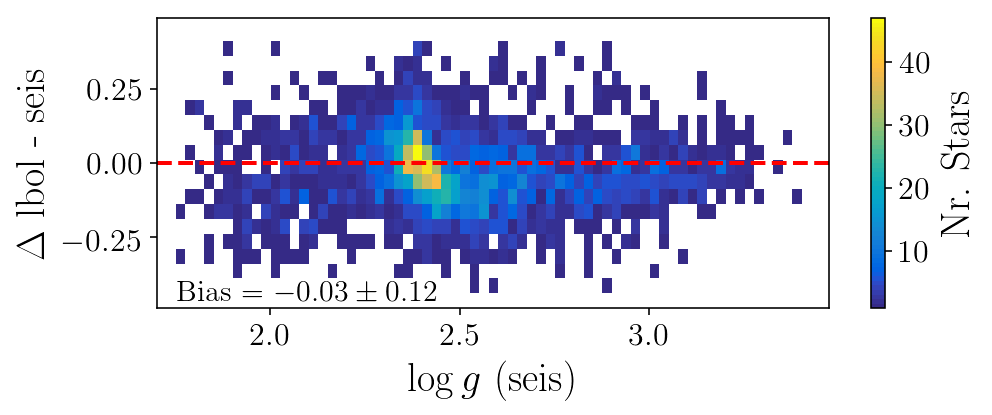

In [8]:
def plot_logg_comparsion_lbol():
    f, ax1= plt.subplots(1, figsize=(7,3))
    p3, x3, y3, s3 = ax1.hist2d(
        seis['LOGG'][match],
        lbol['LOGG'][match] - seis['LOGG'][match],
        bins = (np.arange(1.7,3.5,0.025),np.arange(-0.49,0.49,0.05)), 
        cmin = 1, 
        cmap = parula
        )
    ax1.axhline(0,c='r',lw=2,ls='dashed')
    ax1.set_ylim(-0.49,0.49)
    c3=plt.colorbar(s3,ax=ax1)
    c3.set_label('Nr. Stars')
    ax1.text(0.03,0.03,r'Bias = $'+"{b:5.2f} \pm {s:5.2f}".format(b=np.mean(lbol['LOGG'][match] - seis['LOGG'][match]),s=np.std(lbol['LOGG'][match] - seis['LOGG'][match]))+'$',transform=ax1.transAxes,fontsize=15)
    ax1.set_xlabel(r'$\log g \,\,(\text{seis})$');
    ax1.set_ylabel(r'$\Delta$ lbol - seis');
    plt.tight_layout()
    plt.savefig('figures/seismic_sample_delta_lbol.png',bbox_inches='tight',dpi=300)
    
plot_logg_comparsion_lbol()

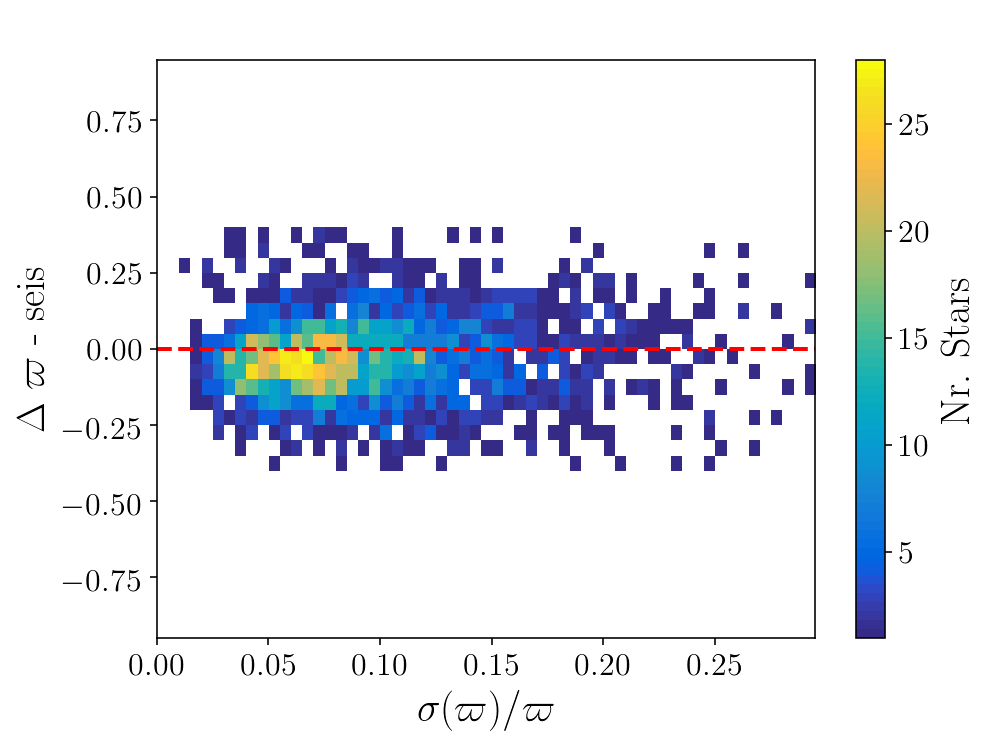

In [22]:
def plot_logg_comparsion_lbol():
    f, ax1= plt.subplots(1, figsize=(7,5))
    p3, x3, y3, s3 = ax1.hist2d(
        iraf['parallax_error'][match]/iraf['parallax'][match],
        lbol['LOGG'][match] - seis['LOGG'][match],
        bins = (np.arange(0,0.3,0.005),np.arange(-1.1,1.11,0.05)), 
        cmin = 1, 
        cmap = parula
        )
    ax1.axhline(0,c='r',lw=2,ls='dashed')
    ax1.set_ylim(-0.95,0.95)
    c3=plt.colorbar(s3,ax=ax1)
    c3.set_label('Nr. Stars')
    ax1.set_xlabel(r'$\sigma(\varpi) / \varpi$');
    ax1.set_ylabel(r'$\Delta$ $\varpi$ - seis');
    plt.tight_layout()
    
plot_logg_comparsion_lbol()
plt.savefig('figures/seismic_sample_delta_lbol_plx.png',bbox_inches='tight',dpi=300)

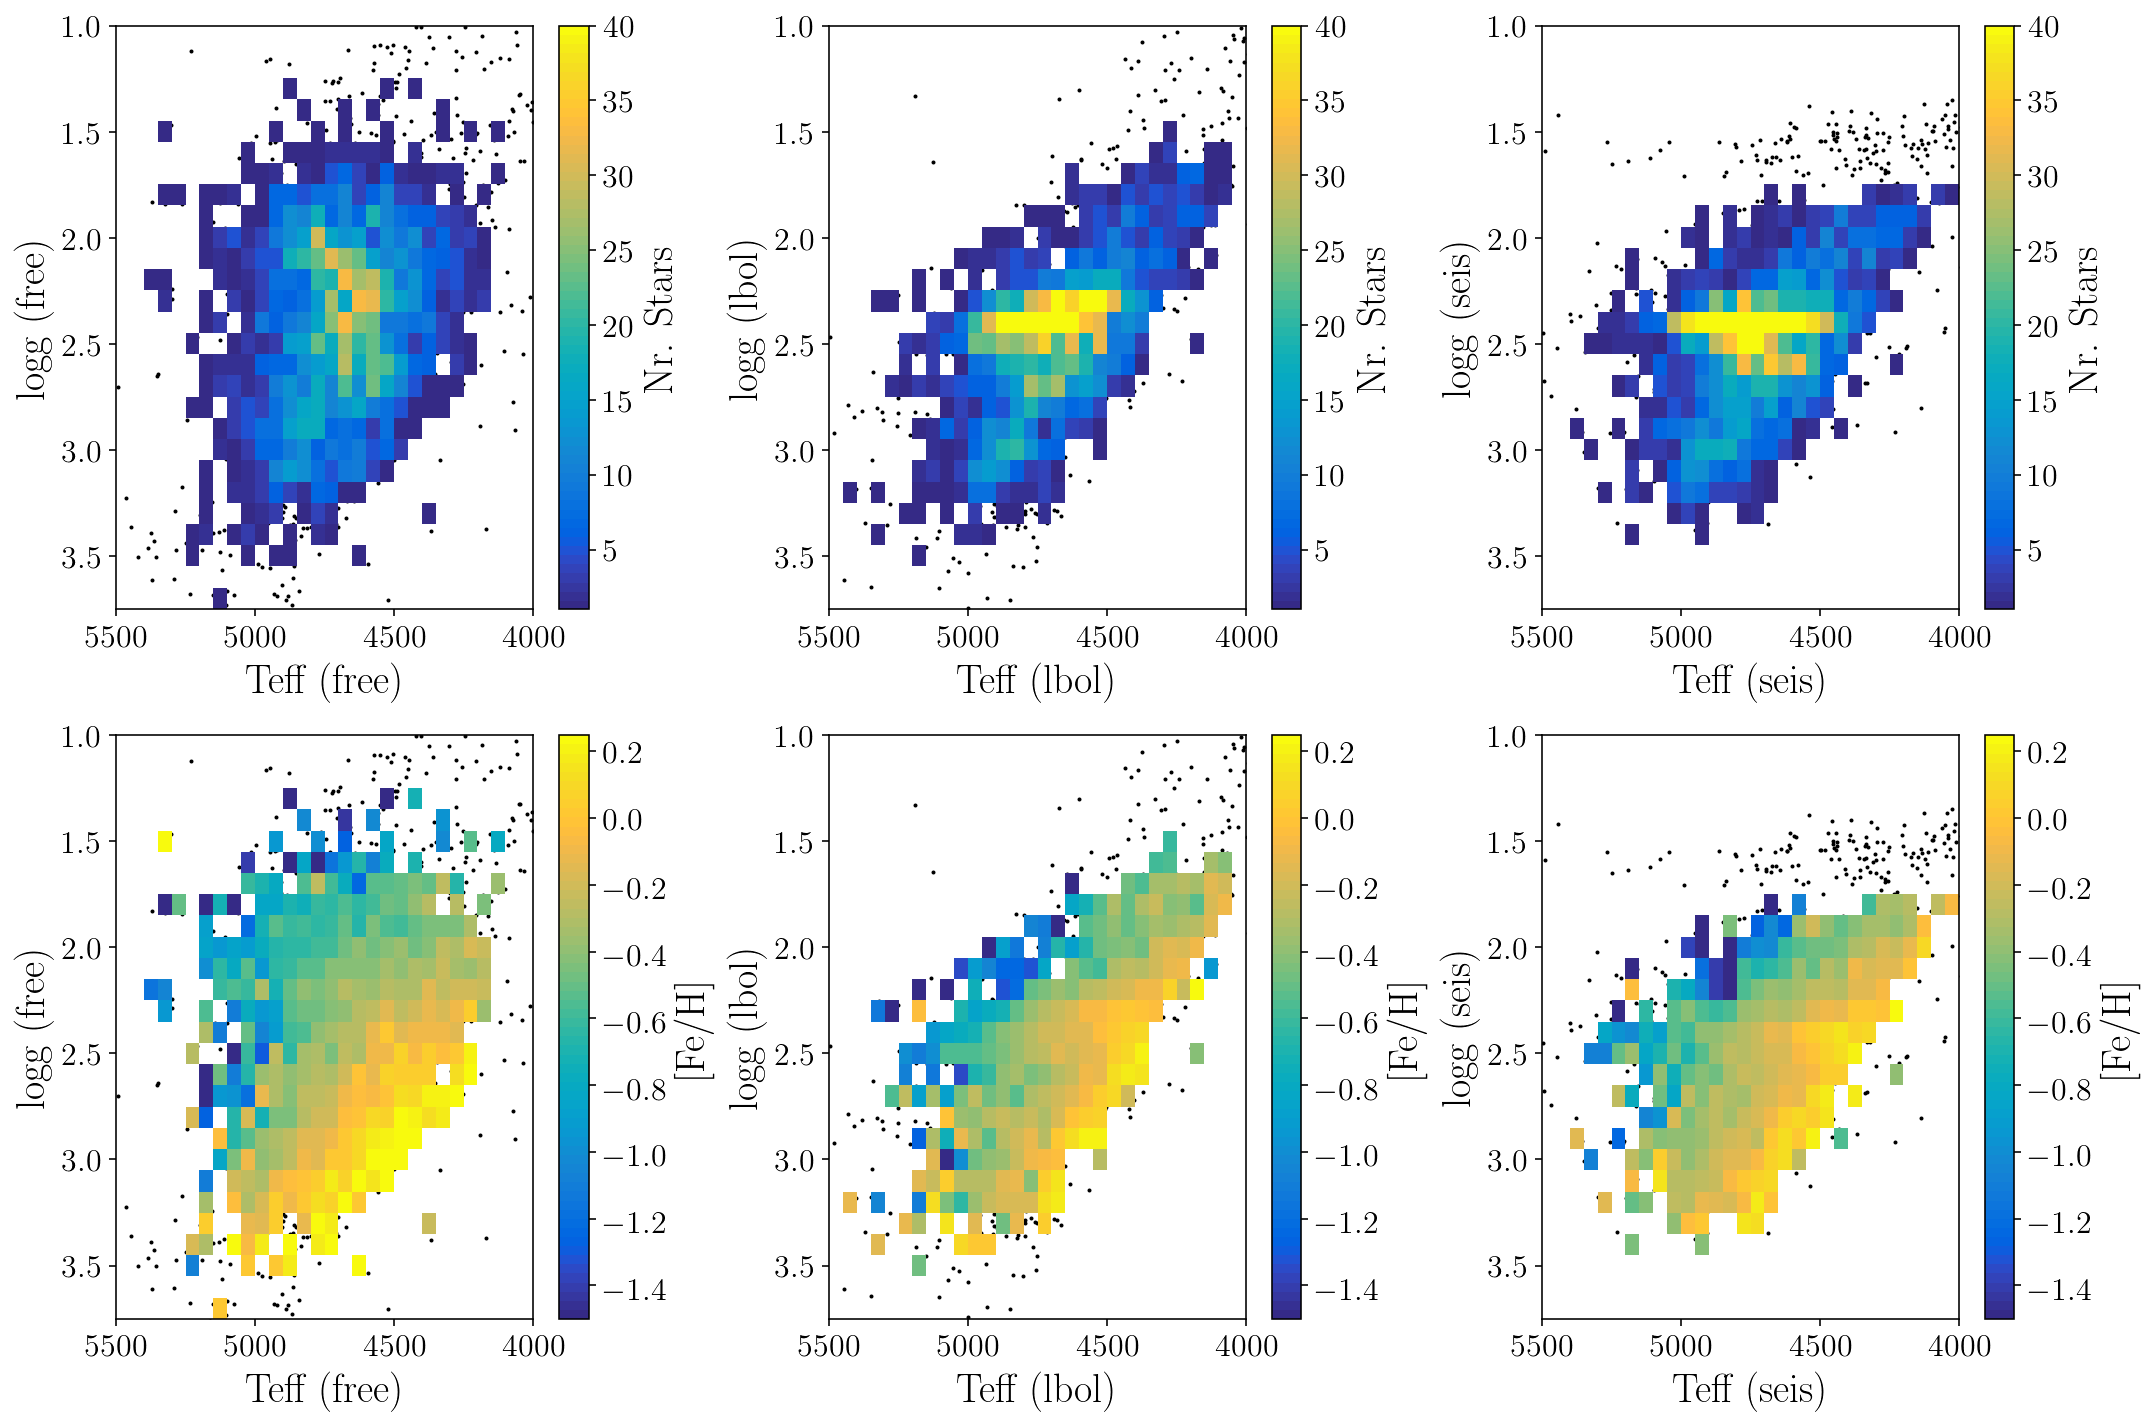

In [8]:
def plot_comparison_3setups(): 
    f, ((ax0, ax1, ax2), (ax3,ax4, ax5)) = plt.subplots(2, 3, figsize = (15,10))

    ax0.scatter(
        free['TEFF'],
        free['LOGG'],
        s=1,c='k',zorder=1
    )
    ax3.scatter(
        free['TEFF'],
        free['LOGG'],
        s=1,c='k',zorder=1
    )
    ax1.scatter(
        lbol['TEFF'],
        lbol['LOGG'],
        s=1,c='k',zorder=1
    )
    ax4.scatter(
        lbol['TEFF'],
        lbol['LOGG'],
        s=1,c='k',zorder=1
    )
    ax2.scatter(
        seis['TEFF'],
        seis['LOGG'],
        s=1,c='k',zorder=1
    )
    ax5.scatter(
        seis['TEFF'],
        seis['LOGG'],
        s=1,c='k',zorder=1
    )

    s0 = plot_density(
        free['TEFF'][match],
        free['LOGG'][match],
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax0,
        vmax=40,
        cmap = parula,
        zorder=2
        )
    c0 = plt.colorbar(s0, ax=ax0)
    c0.set_label('Nr. Stars')
    ax0.set_xlabel('Teff (free)')
    ax0.set_ylabel('logg (free)')
    ax0.set_xlim(5500,4000)
    ax0.set_ylim(3.75,1.0)


    s3 = plot_density(
        free['TEFF'][match],
        free['LOGG'][match],
        weights = free['FEH'][match],
        reduce_fn='mean',
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax3,
        vmin=-1.5,vmax=0.25,
        cmap = parula,
        zorder=2
        )
    c3 = plt.colorbar(s3, ax=ax3)
    c3.set_label('[Fe/H]')
    ax3.set_xlabel('Teff (free)')
    ax3.set_ylabel('logg (free)')
    ax3.set_xlim(5500,4000)
    ax3.set_ylim(3.75,1.0)

    plt.tight_layout()

    #plt.savefig('comparison_3setups_free.pdf',bbox_inches='tight')

    #f, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,5))

    s1 = plot_density(
        lbol['TEFF'][match],
        lbol['LOGG'][match],
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax1,
        vmax=40,
        cmap = parula,
        zorder=2
        )
    c1 = plt.colorbar(s1, ax=ax1)
    c1.set_label('Nr. Stars')
    ax1.set_xlabel('Teff (lbol)')
    ax1.set_ylabel('logg (lbol)')
    ax1.set_xlim(5500,4000)
    ax1.set_ylim(3.75,1.0)

    s4 = plot_density(
        lbol['TEFF'][match],
        lbol['LOGG'][match],
        weights = lbol['FEH'][match],
        reduce_fn='mean',
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax4,
        vmin=-1.5,vmax=0.25,
        cmap = parula,
        zorder=2
        )
    c4 = plt.colorbar(s4, ax=ax4)
    c4.set_label('[Fe/H]')
    ax4.set_xlabel('Teff (lbol)')
    ax4.set_ylabel('logg (lbol)')
    ax4.set_xlim(5500,4000)
    ax4.set_ylim(3.75,1.0)

    #plt.tight_layout()
    #plt.savefig('comparison_3setups_lbol.pdf',bbox_inches='tight')

    #f, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,5))

    s2 = plot_density(
        seis['TEFF'][match],
        seis['LOGG'][match],
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax2,
        vmax=40,
        cmap = parula,
        zorder=2
        )
    c2 = plt.colorbar(s2, ax=ax2)
    c2.set_label('Nr. Stars')
    ax2.set_xlabel('Teff (seis)')
    ax2.set_ylabel('logg (seis)')
    ax2.set_xlim(5500,4000)
    ax2.set_ylim(3.75,1.0)

    s5 = plot_density(
        seis['TEFF'][match],
        seis['LOGG'][match],
        weights = seis['FEH'][match],
        reduce_fn='mean',
        bins = (np.arange(4000,5501,50),np.arange(0.55,3.76,0.1)),
        ax = ax5,
        vmin=-1.5,vmax=0.25,
        cmap = parula,
        zorder=2
        )
    c5 = plt.colorbar(s5, ax=ax5)
    c5.set_label('[Fe/H]')
    ax5.set_xlabel('Teff (seis)')
    ax5.set_ylabel('logg (seis)')
    ax5.set_xlim(5500,4000)
    ax5.set_ylim(3.75,1.0)

    plt.tight_layout();

    plt.savefig('figures/seis_comparison_3setups.png',bbox_inches='tight',dpi=300)
    
plot_comparison_3setups()

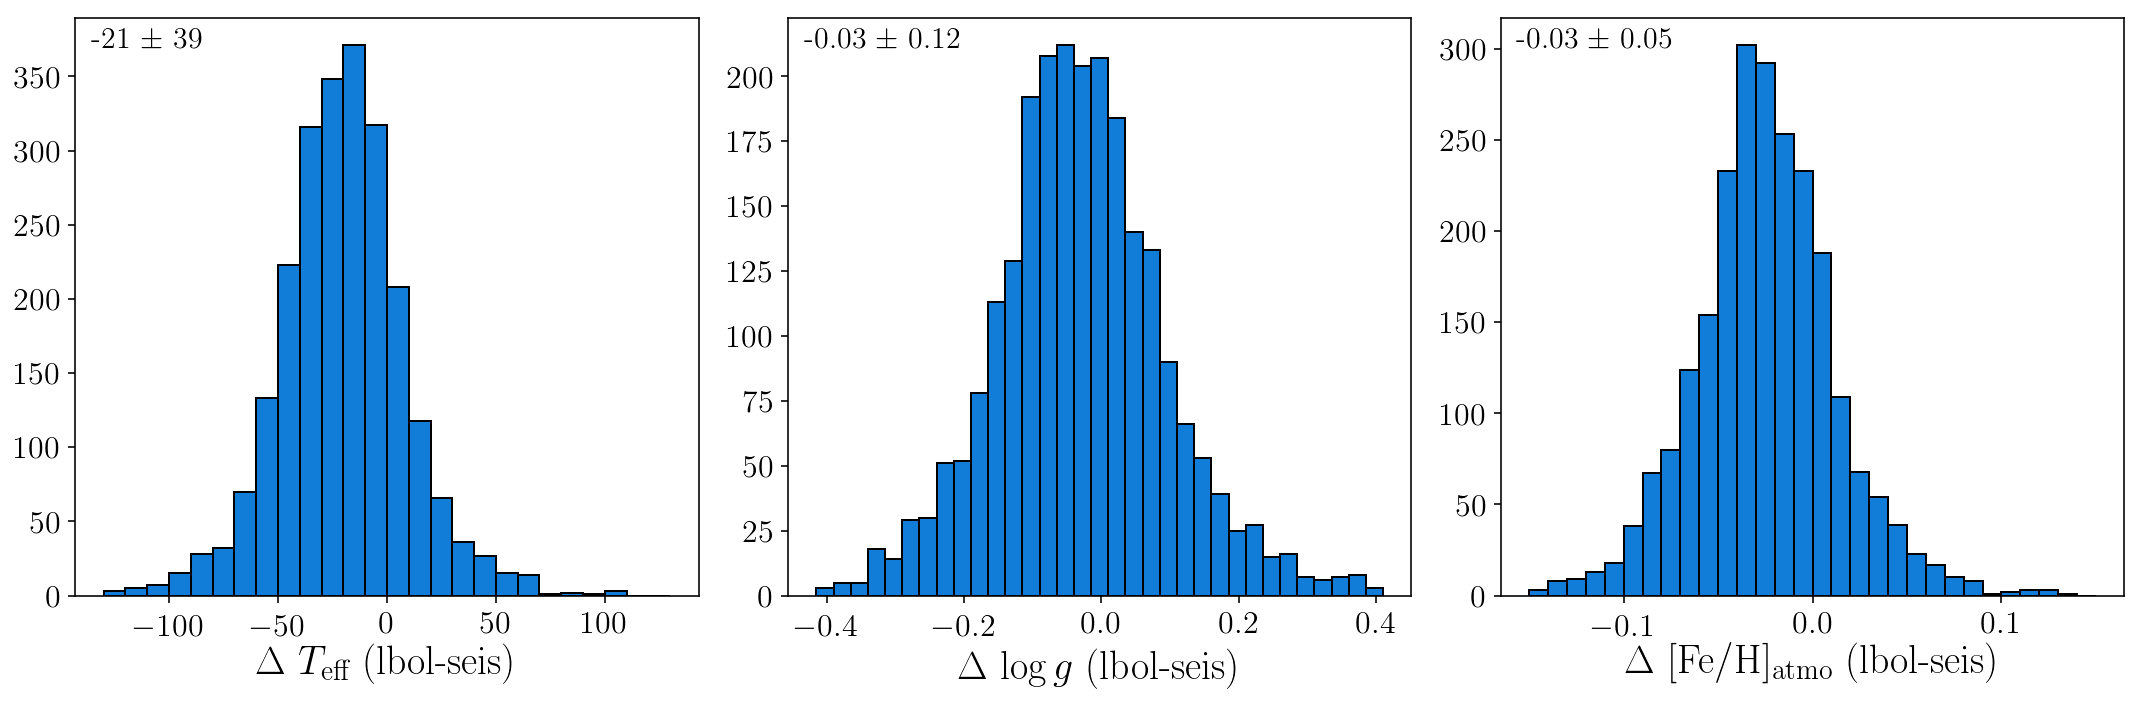

In [8]:
def plot_histograms_seis_lbol():
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    ax1.hist(lbol['TEFF'][match] - seis['TEFF'][match],bins=np.arange(-130,131,10),color=willi_blau,ec='k');
    ax2.hist(lbol['LOGG'][match] - seis['LOGG'][match],bins=np.arange(-0.415,0.4151,0.025),color=willi_blau,ec='k');
    ax3.hist(lbol['FEH'][match] - seis['FEH'][match],bins=np.arange(-0.15,0.151,0.01),color=willi_blau,ec='k');

    ax1.text(0.025,0.95,"{b:5.0f} $\pm$ {s:5.0f}".format(b=np.mean(lbol['TEFF'][match] - seis['TEFF'][match]),s=np.std(lbol['TEFF'][match] - seis['TEFF'][match])),transform=ax1.transAxes,fontsize=15)
    ax2.text(0.025,0.95,"{b:5.2f} $\pm$ {s:5.2f}".format(b=np.mean(lbol['LOGG'][match] - seis['LOGG'][match]),s=np.std(lbol['LOGG'][match] - seis['LOGG'][match])),transform=ax2.transAxes,fontsize=15)
    ax3.text(0.025,0.95,"{b:5.2f} $\pm$ {s:5.2f}".format(b=np.mean(lbol['FEH'][match] - seis['FEH'][match]),s=np.std(lbol['FEH'][match] - seis['FEH'][match])),transform=ax3.transAxes,fontsize=15)

    ax1.set_xlabel(r'$\Delta$ $T_\text{eff}$ (lbol-seis)')
    ax2.set_xlabel(r'$\Delta$ $\log g$ (lbol-seis)')
    ax3.set_xlabel(r'$\Delta$ $\mathrm{[Fe/H]_\text{atmo}}$ (lbol-seis)')

    plt.tight_layout();
    plt.savefig('figures/seis_setup_difference_lbol.png',bbox_inches='tight',dpi=300)
    
plot_histograms_seis_lbol()